In [1]:
from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import datajoint as dj
from pipeline import pipeline_tools, lab, experiment, behavioranal
dj.conn()
import matplotlib.pyplot as plt
import decimal
%matplotlib inline

Connecting rozmar@mesoscale-activity.datajoint.io:3306


# Weight change and water consumption
All mice returned to baseline weight despite they drink little water..

Text(0.5, 1.0, 'Early lick rate during each session')

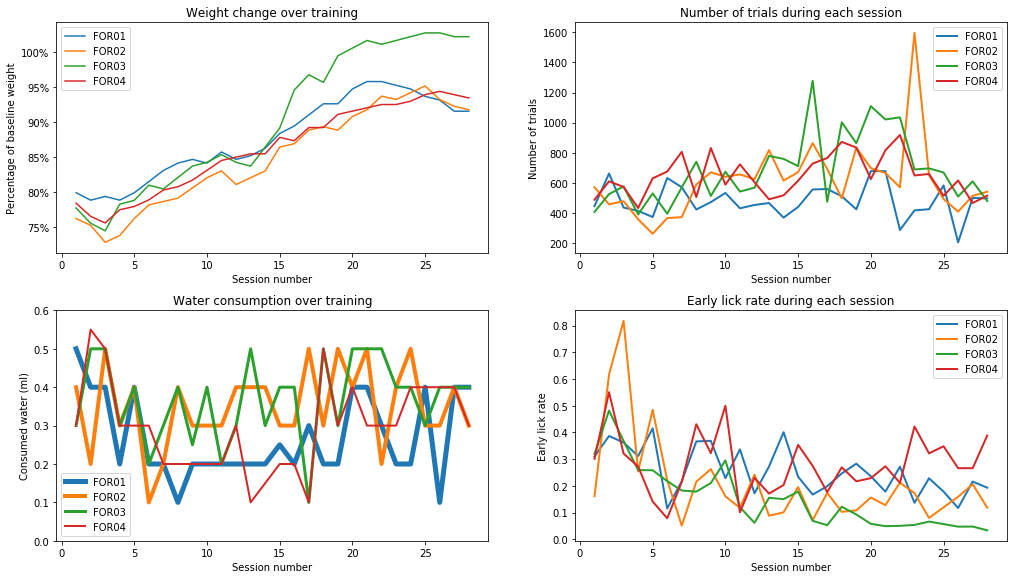

In [2]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
fig=plt.figure()
ax_weight=fig.add_axes([0,0,1,.8])
for i,subject in enumerate(subject_names):
    idx = df_subject_wr['water_restriction_number'] == subject
    weights = df_subject_wr['session_weight'][idx] /df_subject_wr['wr_start_weight'][idx]
    ax_weight.plot(range(1,len(weights)+1),weights.values)
vals = ax_weight.get_yticks()
ax_weight.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax_weight.set_ylabel('Percentage of baseline weight')
ax_weight.set_xlabel('Session number')
ax_weight.legend(subject_names)
ax_weight.set_title('Weight change over training')

ax_water = fig.add_axes([0,-1,1,.8])
for i,subject in enumerate(subject_names):
    idx = df_subject_wr['water_restriction_number'] == subject
    water = df_subject_wr['session_water_earned'][idx]
    ax_water.plot(range(1,len(water)+1),water.values,linewidth=len(subject_names)+1-i)
ax_water.set_ylabel('Consumed water (ml)')
ax_water.set_xlabel('Session number')
ax_water.set_ylim(0, .6)
ax_water.legend(subject_names)
ax_water.set_title('Water consumption over training')

ax_trialnum=fig.add_axes([1.2,0,1,.8])
ax_earlylick=fig.add_axes([1.2,-1,1,.8])
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}
    sessionnum = len(experiment.Session()&key)
    trialnums = list()
    earlylickrates = list()
    for session in range(1,sessionnum+1):    
        key = {'session':session,'subject_id':subject_id}    
        trialnum = len(experiment.SessionTrial() & key)
        trialnums.append(trialnum)    
        df_earlylick = pd.DataFrame((experiment.BehaviorTrial()&key).fetch('early_lick'))
        early_lick_rate = (df_earlylick == 'early').values.sum()/trialnum
        earlylickrates.append(early_lick_rate)
    ax_trialnum.plot(range(1,len(trialnums)+1),trialnums,linewidth=len(subject_names)+1-i)
    ax_earlylick.plot(range(1,len(earlylickrates)+1),earlylickrates,linewidth=len(subject_names)+1-i)
ax_trialnum.legend(subject_names)
ax_trialnum.set_xlabel('Session number')
ax_trialnum.set_ylabel('Number of trials')
ax_trialnum.set_title('Number of trials during each session')

ax_earlylick.legend(subject_names)
ax_earlylick.set_xlabel('Session number')
ax_earlylick.set_ylabel('Early lick rate')
ax_earlylick.set_title('Early lick rate during each session')

# Autowater
Autowater (water cue after multiple miss trials) was not used from week 2, except for FOR01 who had a huge bias on a few days
(autowater was turned on if the animal igored 10 trials in a row at the end of the session, these are the small bumps from the second week)

Text(0.5, 1.0, 'Autowater')

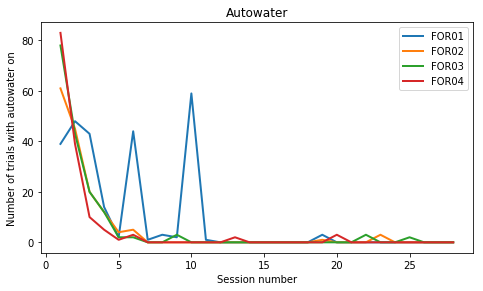

In [47]:
fig=plt.figure()
ax_autowater=fig.add_axes([0,0,1,.8])
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}
    sessionnum = len(experiment.Session()&key)
    autowater_nums = list()
    
    for session in range(1,sessionnum+1):  
        key = {'session':session,'subject_id':subject_id}    
        autowater_num = len((experiment.TrialNote()&key))
        autowater_nums.append(autowater_num)
    ax_autowater.plot(range(1,len(autowater_nums)+1),autowater_nums,linewidth=len(subject_names)+1-i)    
ax_autowater.legend(subject_names)
ax_autowater.set_xlabel('Session number')
ax_autowater.set_ylabel('Number of trials with autowater on')
ax_autowater.set_title('Autowater')   

# reaction times for the last session:
The first two mice (Bari-Cohen training) are trying to guess the GO cue

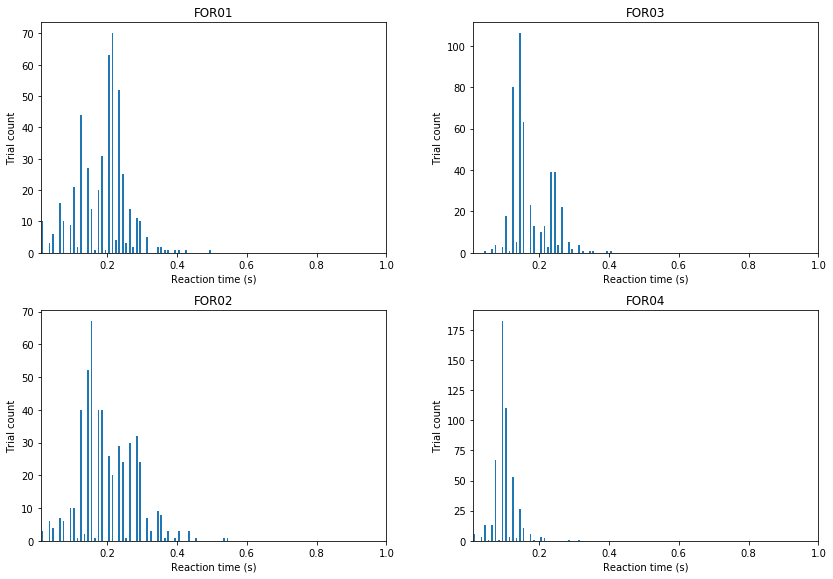

In [6]:
session = experiment.Session().fetch('session').max()
key = {'session':session}
df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
fig=plt.figure()
ax_RT = list()
for i,subject in enumerate(subject_names):
    ax_RT.append(fig.add_axes([np.floor((i/2)%2),-1*(i%2),.8,.8]))
    idx = df_reactiontime['water_restriction_number'] == subject
    bins = df_reactiontime['reaction_time_bins'][idx].values[0][1:]
    edges = [np.min(bins),np.max(bins)]
    bins = bins - (bins[1] -bins[0])/2
    vals = df_reactiontime['reaction_time_values_all_trials'][idx].values.tolist()[0]
    ax_RT[-1].bar(bins,vals, (bins[1] -bins[0])/2)
    ax_RT[-1].set_xlim(edges)
    ax_RT[-1].set_title(subject)
    ax_RT[-1].set_xlabel('Reaction time (s)')
    ax_RT[-1].set_ylabel('Trial count')

# Number of licks on miss trials after the first lick in each session:
(if the retraction is fast enough, it should be 0)  
Sessions 1-7 : softcode and slow motor movement  
Sessions 7-11 : softcode and fast motor movement  
Sessions 12-19: same as above but two bpods controlled from the same PC  
Sessions 19- : zaber motor is directly triggered  

Text(0.5, 1.0, 'Lick count on miss trials')

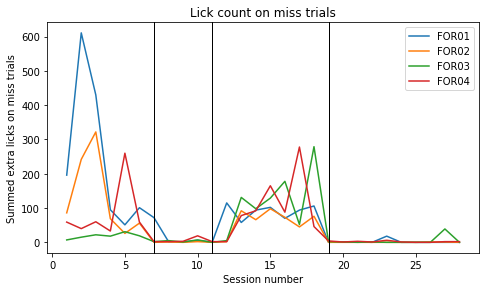

In [19]:
#%% licks on miss trials
df_misslicknums = pd.DataFrame()
fig=plt.figure()
ax_misslick = fig.add_axes([0,0,1,.8])
for wr_name in subject_names:
    #%
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}   
    df_lickrhythm = pd.DataFrame((behavioranal.SessionLickRhythmHistogram() & key)*(lab.WaterRestriction &key))
    #%
    
    sessionnum = list()
    licknum = list()
    for i,session in enumerate(df_lickrhythm['session']):
        idx = df_lickrhythm['session'] == session
        bins = df_lickrhythm['lick_rhythm_bins'][idx].values[0][1:]
        edges = [np.min(bins),np.max(bins)]
        bins = bins - (bins[1] -bins[0])/2 
        vals = df_lickrhythm['lick_rhythm_values_miss_trials'][idx].values.tolist()[0]
        sessionnum.append(session)
        licknum.append(vals[bins>.015].sum())       
    ax_misslick.plot(sessionnum,licknum)
protocolchanges = [7,11,19]
ylimedges = ax_misslick.get_ylim()
ax_misslick.plot(protocolchanges,np.ones(len(protocolchanges))*np.mean(ylimedges),'k|',markersize = np.diff(ylimedges))
ax_misslick.set_ylabel('Summed extra licks on miss trials')
ax_misslick.set_xlabel('Session number')
ax_misslick.legend(subject_names)
ax_misslick.set_title('Lick count on miss trials')


#Behavior on block switches for all animals

453478
453475
453477
453476


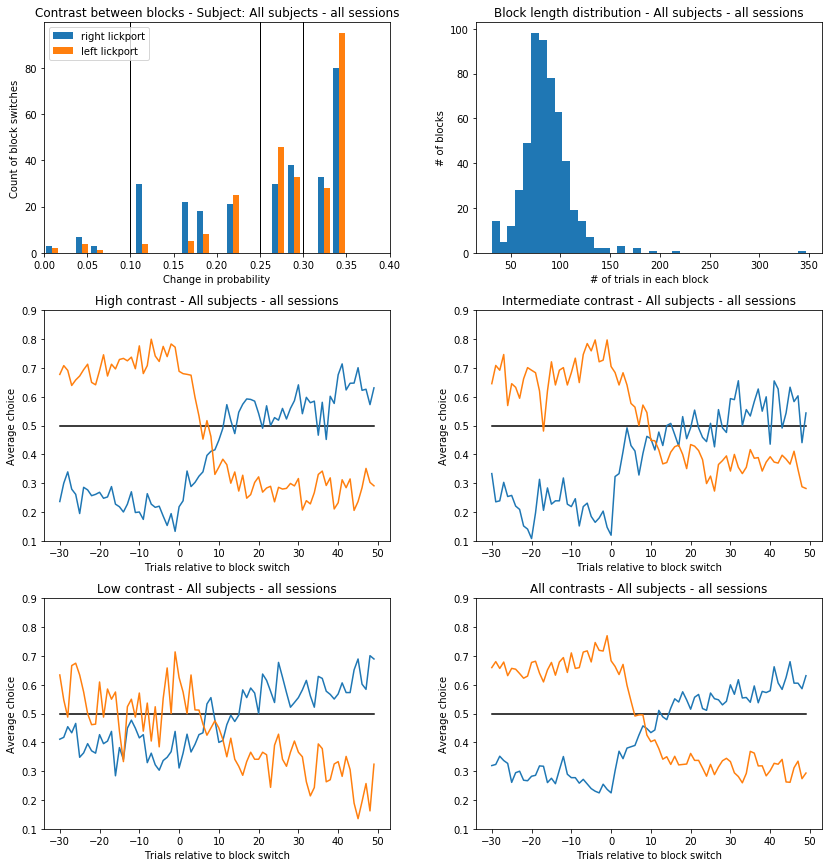

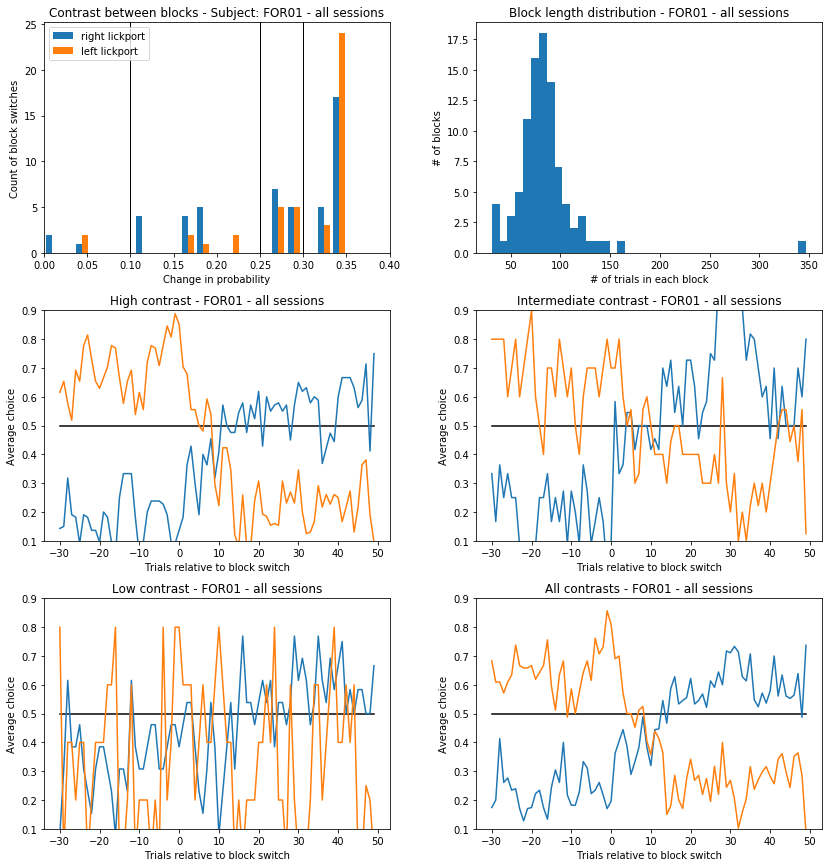

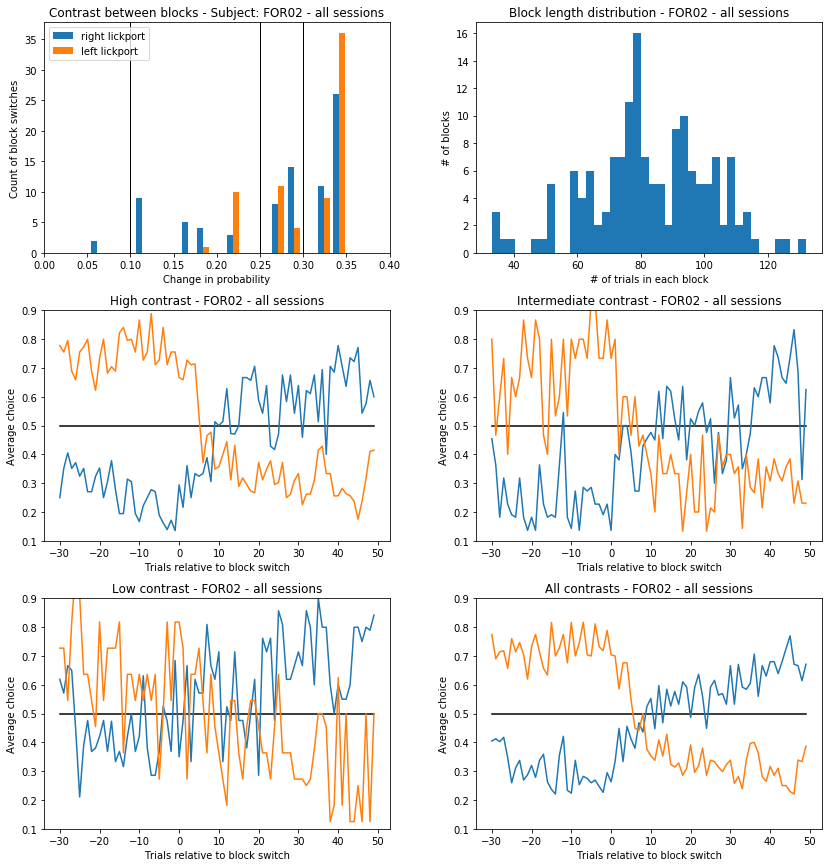

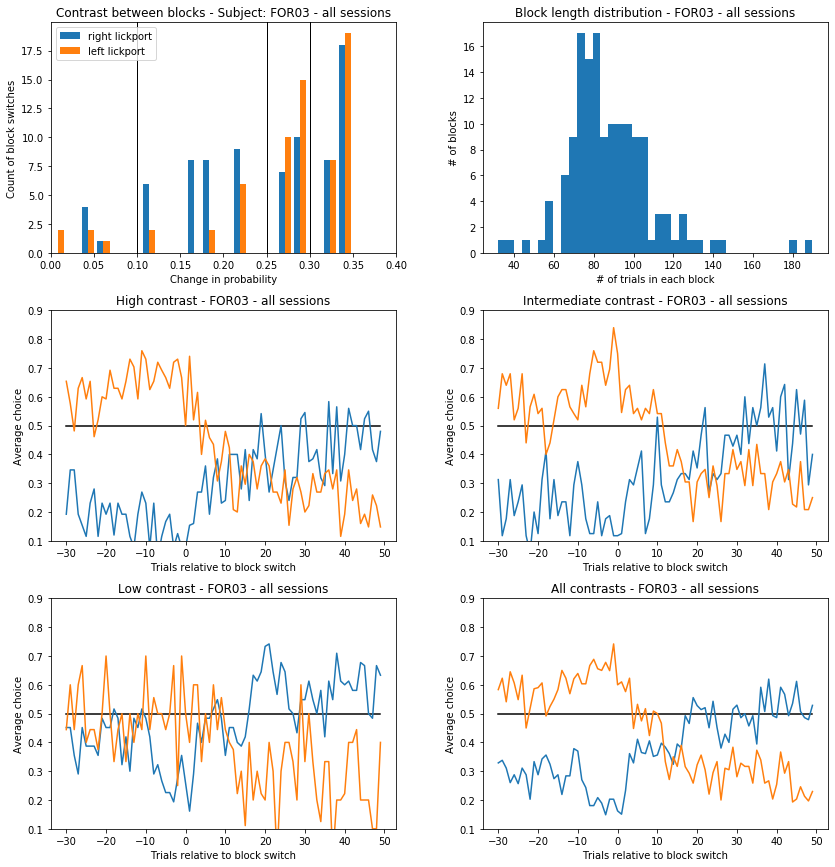

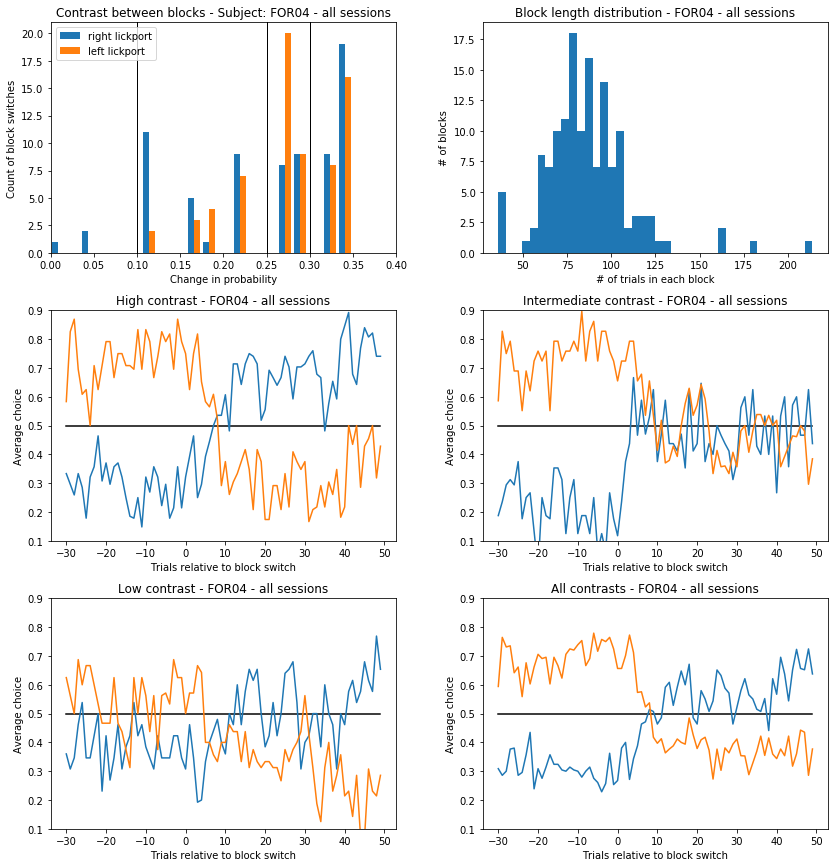

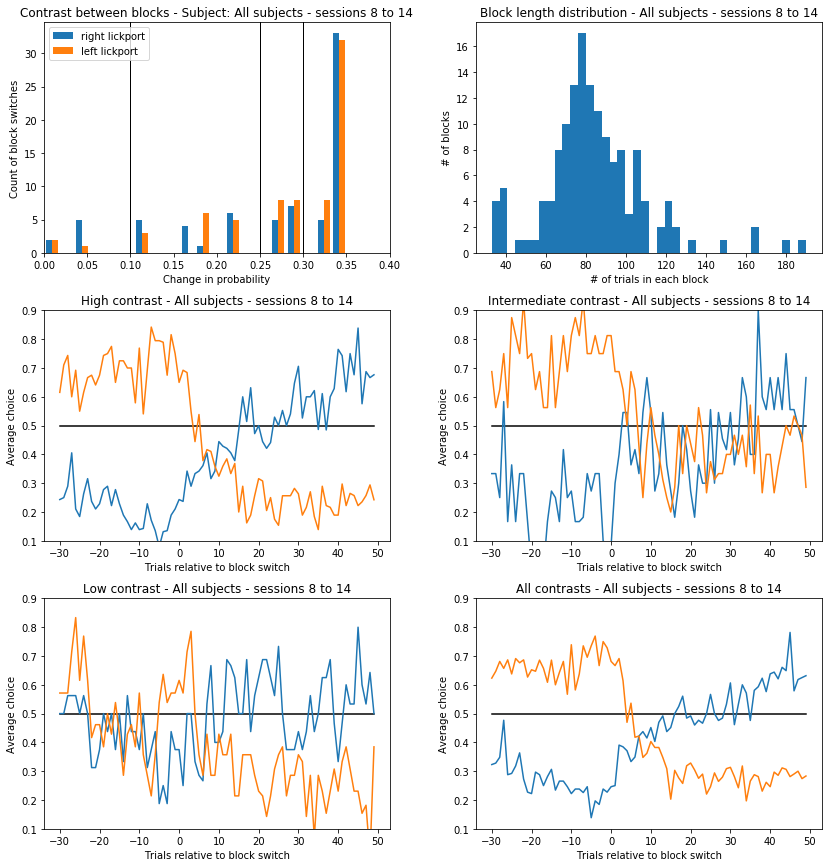

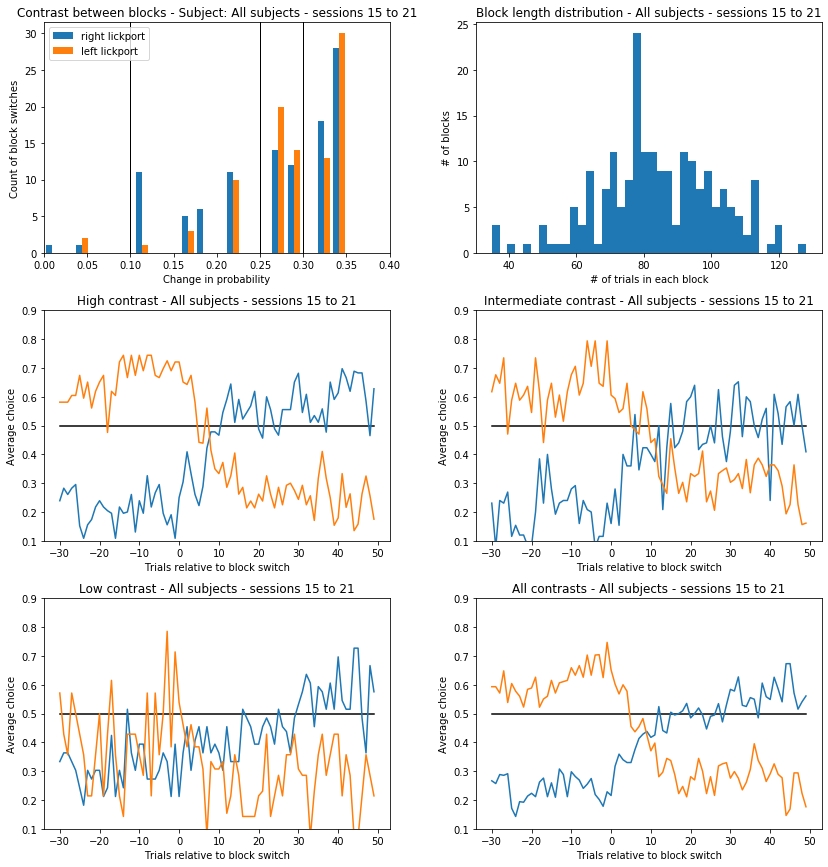

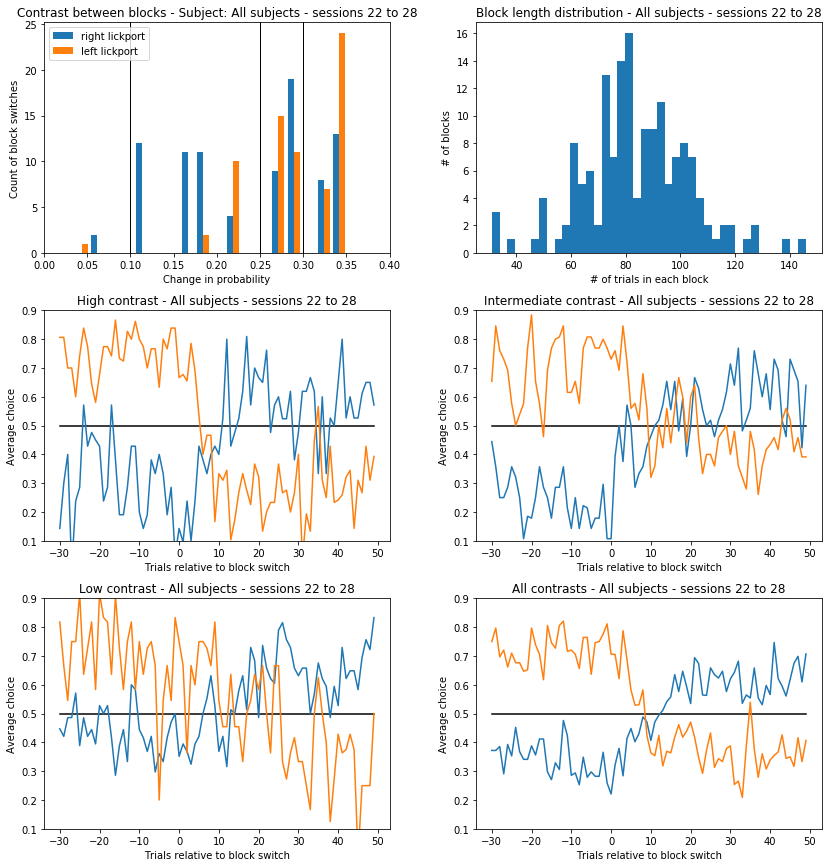

In [18]:
def plot_block_switches(wr_name = None,sessions = None):
    if wr_name == None:
        key = dict()
        wr_name = 'All subjects'
    else:
        subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
        key ={'subject_id':subject_id}
        
        print(subject_id)
    if sessions == None:
        df_block_starts = pd.DataFrame(behavioranal.SessionBlockSwitchChoices() & 'session > 5' & key)
        session_name = 'all sessions'
    elif len(sessions) == 1:
        df_block_starts = pd.DataFrame(behavioranal.SessionBlockSwitchChoices() & 'session ='+str(sessions) & key)
        session_name = 'session '+str(sessions)
    else:
        df_block_starts = pd.DataFrame(behavioranal.SessionBlockSwitchChoices() & 'session >='+str(np.min(sessions))& 'session <='+str(np.max(sessions)) & key)
        session_name = 'sessions '+str(np.min(sessions))+' to '+str(np.max(sessions))
    contrast_edges = [.1,.25,.3]
    bigchoicematrix = None
    p_r_change = None
    p_l_change = None
    p_r_next = None
    p_r_prev = None
    next_block_length = None
    for idx, line in df_block_starts.iterrows():
        if len(line['p_r_change']) > 0:
            if bigchoicematrix is None:
                bigchoicematrix = line['choices_matrix']        
                p_r_change  = line['p_r_change']        
                p_l_change  = line['p_l_change']  
                next_block_length  = line['block_length_next']   
                p_r_next  = line['p_r_next']   
                p_r_prev  = line['p_r_prev']   
            else:
                bigchoicematrix = np.concatenate((bigchoicematrix,line['choices_matrix']))
                p_r_change  =  np.concatenate((p_r_change,line['p_r_change']))
                p_l_change  =  np.concatenate((p_l_change,line['p_l_change']))
                next_block_length  =  np.concatenate((next_block_length,line['block_length_next']))       
                p_r_next  =  np.concatenate((p_r_next,line['p_r_next']))       
                p_r_prev  =  np.concatenate((p_r_prev,line['p_r_prev']))   
    
    fig=plt.figure()
    ax1=fig.add_axes([0,0,.8,.8])
    ax1.hist([p_r_change,p_l_change],40)
    ylimedges = ax1.get_ylim()
    ax1.set_title('Contrast between blocks - Subject: '+wr_name+' - '+session_name)
    ax1.set_ylabel('Count of block switches')
    ax1.set_xlabel('Change in probability')
    ax1.legend(['right lickport','left lickport','contrast groups'])
    ax1.plot(contrast_edges,np.ones(len(contrast_edges))*np.mean(ylimedges),'k|',markersize = 500)
    ax1.set_xlim(0,.4)
    
    ax2=fig.add_axes([1,0,.8,.8])
    ax2.hist(next_block_length,40)
    ax2.set_title('Block length distribution - '+wr_name+' - '+session_name)
    ax2.set_ylabel('# of blocks')
    ax2.set_xlabel('# of trials in each block')
    
    ax3=fig.add_axes([0,-1,.8,.8])
    idx = (p_r_change >0) & (p_r_change >.3) & (np.abs(p_r_change) <1)
    ax3.plot(np.arange(-30,50),np.ones(80)*.5,'k-')
    ax3.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    idx = (p_l_change > 0) & (p_l_change > .3) & (np.abs(p_r_change) <1)
    ax3.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    ax3.set_title('High contrast - '+wr_name+' - '+session_name)
    ax3.set_xlabel('Trials relative to block switch')
    ax3.set_ylabel('Average choice')
    ax3.set_ylim(.1,.9)
    
    ax4=fig.add_axes([1,-1,.8,.8])
    idx = (p_r_change >.25) & (p_r_change <.3) & (np.abs(p_r_change) <1)
    ax4.plot(np.arange(-30,50),np.ones(80)*.5,'k-')
    ax4.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    idx = (p_l_change > .25) & (p_l_change < .3) & (np.abs(p_r_change) <1)
    ax4.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    ax4.set_title('Intermediate contrast - '+wr_name+' - '+session_name)
    ax4.set_xlabel('Trials relative to block switch')
    ax4.set_ylabel('Average choice')
    ax4.set_ylim(.1,.9)
    
    ax5=fig.add_axes([0,-2,.8,.8])
    idx = (p_r_change >.1) & (p_r_change <.25) & (np.abs(p_r_change) <1)
    ax5.plot(np.arange(-30,50),np.ones(80)*.5,'k-')
    ax5.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    idx = (p_l_change > .1) & (p_l_change < .25) & (np.abs(p_r_change) <1)
    ax5.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    ax5.set_title('Low contrast - '+wr_name+' - '+session_name)
    ax5.set_xlabel('Trials relative to block switch')
    ax5.set_ylabel('Average choice')
    ax5.set_ylim(.1,.9)
    
    ax6=fig.add_axes([1,-2,.8,.8])
    idx = (p_r_change >.1) & (p_r_change <1) & (np.abs(p_r_change) <1)
    ax6.plot(np.arange(-30,50),np.ones(80)*.5,'k-')
    ax6.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    idx = (p_l_change > .1) & (p_l_change < 1) & (np.abs(p_r_change) <1)
    ax6.plot(np.arange(-30,50),np.nanmean(bigchoicematrix[idx,:],0))
    ax6.set_title('All contrasts - '+wr_name+' - '+session_name)
    ax6.set_xlabel('Trials relative to block switch')
    ax6.set_ylabel('Average choice')
    ax6.set_ylim(.1,.9)
   
plot_block_switches()
plot_block_switches('FOR01')
plot_block_switches('FOR02')
plot_block_switches('FOR03')
plot_block_switches('FOR04')
plot_block_switches(sessions = [8, 14])
plot_block_switches(sessions = [15, 21])
plot_block_switches(sessions = [22, 28])


# Logistic regression for weeks 2-4

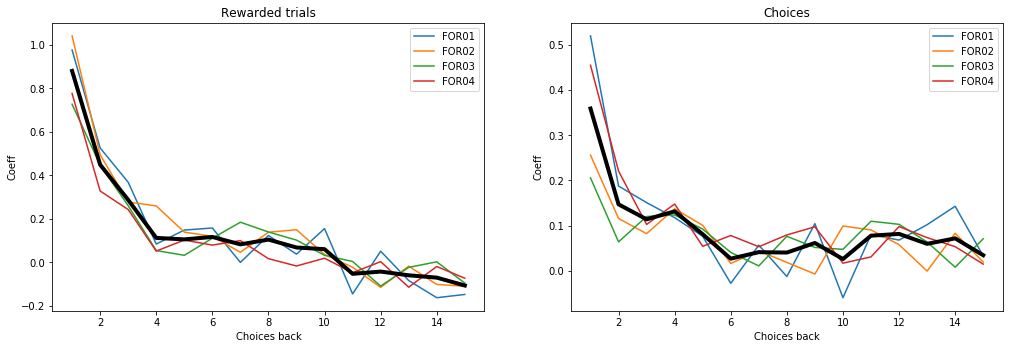

In [18]:
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficients())
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])  
ax2=fig.add_axes([1.2,0,1,1])  
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'][idx].values[0])
ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Rewarded trials')
ax1.legend(subject_names)
ax2.set_xlabel('Choices back')
ax2.set_ylabel('Coeff')
ax2.set_title('Choices')
ax2.legend(subject_names)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'].mean(),'k-',linewidth = 4)

# Logistic regression session by session

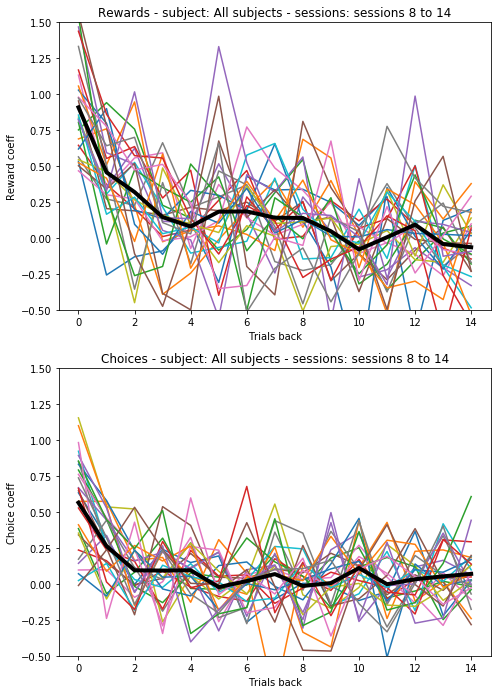

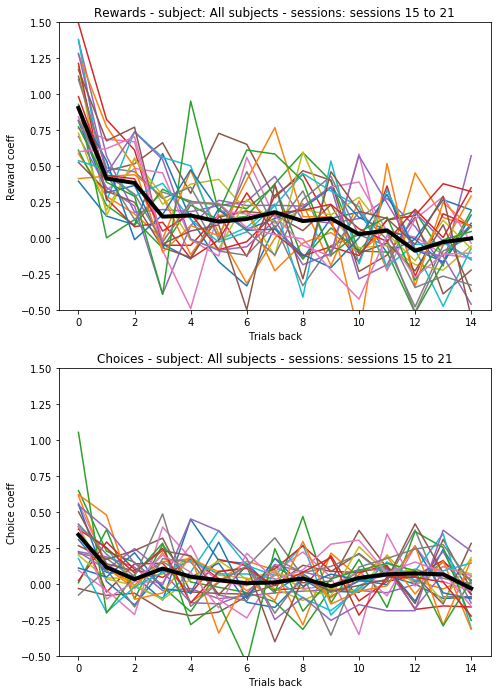

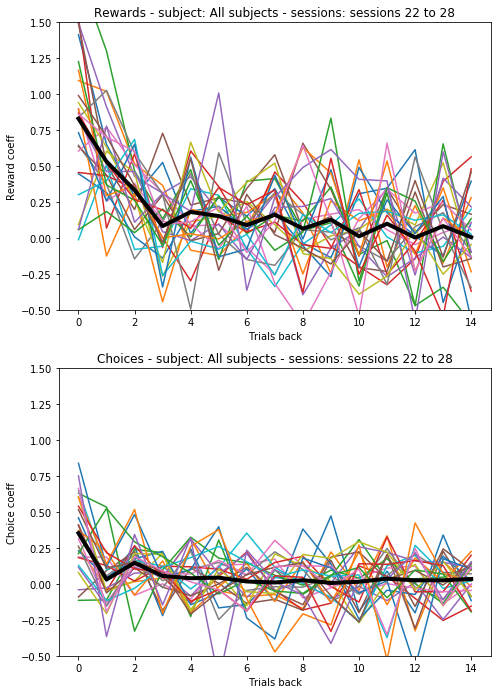

In [53]:
def plotregressionaverage(wr_name = None, sessions = None):
    if wr_name == None:
        key = dict()
        wr_name = 'All subjects'
    else:
        subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
        key ={'subject_id':subject_id}
        
        print(subject_id)
    if sessions == None:
        df_coefficients = pd.DataFrame(behavioranal.SessionFittedChoiceCoefficients() & 'session > 5' & key)
        session_name = 'all sessions'
    elif len(sessions) == 1:
        df_coefficients = pd.DataFrame(behavioranal.SessionFittedChoiceCoefficients() & 'session ='+str(sessions) & key)
        session_name = 'session '+str(sessions)
    else:
        df_coefficients = pd.DataFrame(behavioranal.SessionFittedChoiceCoefficients() & 'session >='+str(np.min(sessions))& 'session <='+str(np.max(sessions)) & key)
        session_name = 'sessions '+str(np.min(sessions))+' to '+str(np.max(sessions))
    
    fig=plt.figure()
    ax1=fig.add_axes([0,0,1,1])  
    ax2=fig.add_axes([0,-1.2,1,1]) 
    for line in df_coefficients.iterrows():
        ax1.plot(line[1]['coefficients_rewards'])
        ax2.plot(line[1]['coefficients_choices'])
    ax1.plot(df_coefficients['coefficients_rewards'].mean(),'k-',linewidth = 4)
    ax2.plot(df_coefficients['coefficients_choices'].mean(),'k-',linewidth = 4)
    ax1.set_xlabel('Trials back')
    ax1.set_ylabel('Reward coeff')
    ax1.set_title('Rewards - subject: ' + wr_name + ' - sessions: ' + session_name)
    ax1.set_ylim([-.5, 1.5])
    ax2.set_xlabel('Trials back')
    ax2.set_ylabel('Choice coeff')
    ax2.set_title('Choices - subject: ' + wr_name + ' - sessions: ' + session_name)
    ax2.set_ylim([-.5, 1.5])
plotregressionaverage(sessions = [8,14])
plotregressionaverage(sessions = [15,21])
plotregressionaverage(sessions = [22,28])

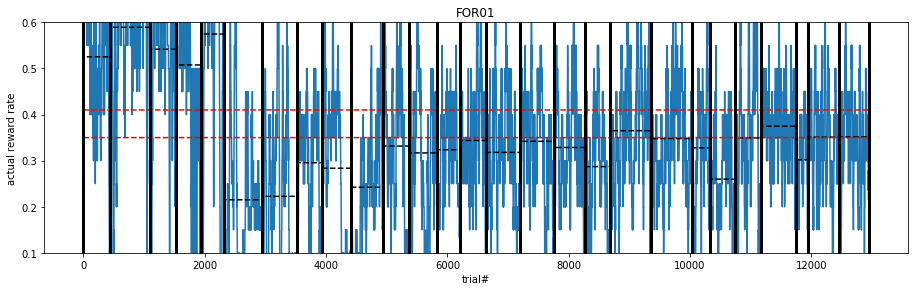

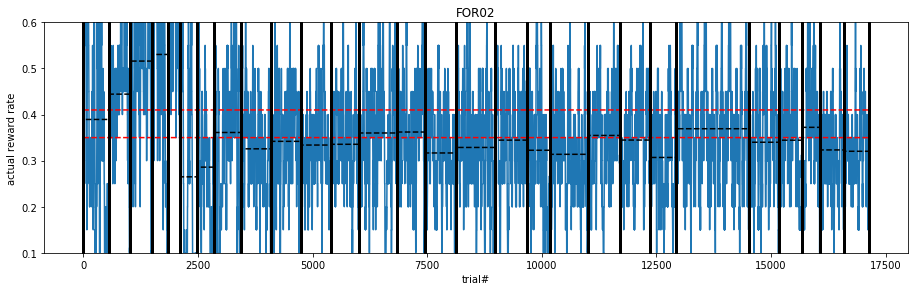

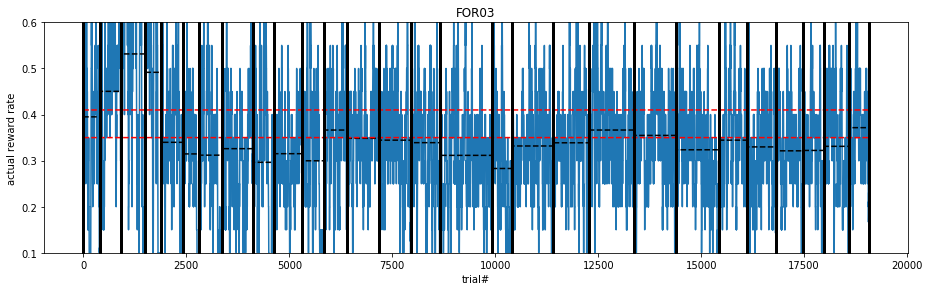

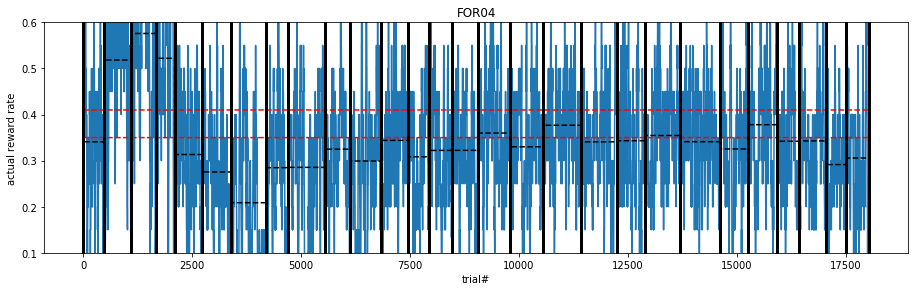

In [84]:
def plot_reward_rate(wr_name):
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {
           'subject_id':subject_id,
           }

    df_rewardratio = pd.DataFrame(behavioranal.SessionRewardRatio() & key)
    rewardratio = list()
    sessionrewardratio = list()
    sessionstart = list([0])
    maxrewardratio = list([0])
    meanrewardratio = list([0])
    for reward_now,maxreward_now in zip(df_rewardratio['session_reward_ratio'],df_rewardratio['session_maximal_reward_ratio'] ):
        rewardratio.extend(reward_now)
        meanrewardratio.extend(np.ones(len(reward_now))*np.mean(reward_now))
        maxrewardratio.extend(maxreward_now)
        sessionrewardratio.append(np.median(reward_now))
        sessionstart.append(len(rewardratio)-1)
    rewardratio = np.array(rewardratio)
    maxrewardratio = np.array(maxrewardratio)
    fig=plt.figure()
    ax1=fig.add_axes([0,0,2,.8])
    ax1.plot(rewardratio)
    ax1.plot(meanrewardratio,'k--')
    ax1.plot(np.ones(len(meanrewardratio))*.35,'r--')
    ax1.plot(np.ones(len(meanrewardratio))*.41,'r--')
    ax1.plot(sessionstart,np.ones(len(sessionstart))*.5,'k|',markersize=500,markeredgewidth = 3)
    ax1.set_ylim([.1,.6])
    ax1.set_ylabel('actual reward rate')
    ax1.set_xlabel('trial#')
    ax1.set_title(wr_name)
plot_reward_rate('FOR01')
plot_reward_rate('FOR02')
plot_reward_rate('FOR03')
plot_reward_rate('FOR04')

# One nice session:

In [2]:
wr_name = 'FOR02'
subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
session = 23
df_behaviortrial = pd.DataFrame(((experiment.BehaviorTrial() & 'subject_id = '+str(subject_id) & 'session = '+str(session)) * experiment.SessionTrial() * experiment.SessionBlock()).fetch())
df_session=pd.DataFrame(experiment.Session() & 'session = '+str(session) & 'subject_id = '+str(subject_id))
df_session

,subject_id,session,session_date,session_time,username,rig
0,453475,23,2019-07-17,16:39:04,rozsam,Training-Tower-2


In [3]:
df_behaviortrial['trial_choice_plot'] = np.nan
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='left']=0
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='right']=1
df_behaviortrial['reward_ratio']=df_behaviortrial['p_reward_right']/(df_behaviortrial['p_reward_right']+df_behaviortrial['p_reward_left'])

/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
df_behaviortrial['trial_choice_plot'] = np.nan
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='left']=0
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='right']=1
df_behaviortrial['reward_ratio']=df_behaviortrial['p_reward_right']/(df_behaviortrial['p_reward_right']+df_behaviortrial['p_reward_left'])

binsize = 5
bias = list()
for idx in range(len(df_behaviortrial)):
    if idx < round(binsize/2) or idx > len(df_behaviortrial)-round(binsize/2):
        bias.append(np.nan)
    else:
        bias_now = np.mean(df_behaviortrial['trial_choice_plot'][idx-round(binsize/2):idx+round(binsize/2)])
        bias.append(bias_now)
        
rewarded = (df_behaviortrial['outcome']=='hit')
unrewarded = (df_behaviortrial['outcome']=='miss')

choicesback = 10
rewardratio_L = list()
rewardratio_R = list()
#rewardratio_combined = list()
for idx in range(len(df_behaviortrial)):
    if idx < choicesback:
        rewardratio_L.append(np.nan)
        rewardratio_R.append(np.nan)
    else:
        choices_L=sum((df_behaviortrial['trial_choice']=='left')[idx-choicesback:idx])
        rewards_L=sum(((df_behaviortrial['trial_choice']=='left')&(df_behaviortrial['outcome']=='hit'))[idx-choicesback:idx])
        choices_R=sum((df_behaviortrial['trial_choice']=='right')[idx-choicesback:idx])
        rewards_R=sum(((df_behaviortrial['trial_choice']=='right')&(df_behaviortrial['outcome']=='hit'))[idx-choicesback:idx])
        if choices_L == 0:
            rewardratio_L_now= np.nan
        else:
            rewardratio_L_now = rewards_L/choices_L
        rewardratio_L.append(rewardratio_L_now)
        
        if choices_R == 0:
            rewardratio_R_now= np.nan
        else:
            rewardratio_R_now = rewards_R/choices_R
        
        rewardratio_R.append(rewardratio_R_now)

rewardratio_R = np.array(rewardratio_R)
rewardratio_L = np.array(rewardratio_L)
rewardratio_L[np.isnan(rewardratio_L)]=0
rewardratio_R[np.isnan(rewardratio_R)]=0



/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


(0, 400)

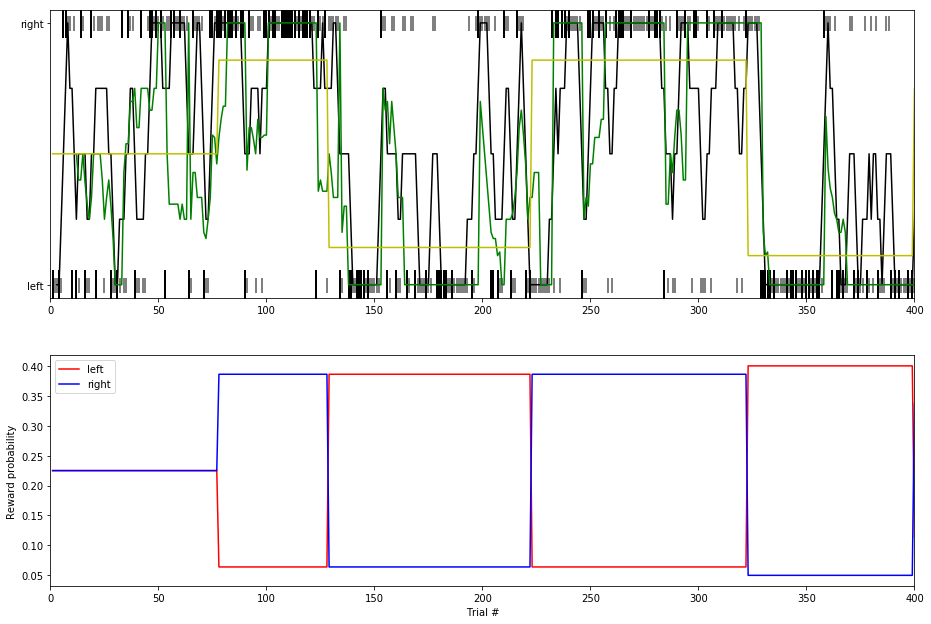

In [50]:

fig=plt.figure()
ax1=fig.add_axes([0,0,2,1])
ax1.plot(df_behaviortrial['trial'][rewarded],df_behaviortrial['trial_choice_plot'][rewarded],'k|',color='black',markersize=30,markeredgewidth=2)
ax1.plot(df_behaviortrial['trial'][unrewarded],df_behaviortrial['trial_choice_plot'][unrewarded],'|',color='gray',markersize=15,markeredgewidth=2)
ax1.plot(df_behaviortrial['trial'],bias,'k-')
ax1.plot(df_behaviortrial['trial'],rewardratio_R / (rewardratio_R+rewardratio_L),'g-')
ax1.plot(df_behaviortrial['trial'],df_behaviortrial['reward_ratio'],'y-')
ax1.set_yticks((0,1))
ax1.set_yticklabels(('left','right'))

ax2=fig.add_axes([0,-1,2,.8])
ax2.plot(df_behaviortrial['trial'],df_behaviortrial['p_reward_left'],'r-')
ax2.plot(df_behaviortrial['trial'],df_behaviortrial['p_reward_right'],'b-')
ax2.set_ylabel('Reward probability')
ax2.set_xlabel('Trial #')
ax2.legend(['left','right'])

ax1.set_xlim(00, 600)
ax2.set_xlim(00, 600)

In [39]:
#np.unique(rewardratio_R / (rewardratio_R+rewardratio_L))
